In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [ ]:
'''#Load metadata
metadata_df = pd.read_csv('/content/drive/MyDrive/gunshot-audio-all-metadata.csv')

def load_and_preprocess_audio(file_path, max_length=None):
    audio, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

    if max_length:
        if mfcc.shape[1] > max_length:
            mfcc = mfcc[:, :max_length]
        else:
            pad_width = max_length - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    return mfcc'''

"#Load metadata\nmetadata_df = pd.read_csv('/content/drive/MyDrive/gunshot-audio-all-metadata.csv')\n\ndef load_and_preprocess_audio(file_path, max_length=None):\n    audio, sr = librosa.load(file_path, sr=None)\n    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)\n\n    if max_length:\n        if mfcc.shape[1] > max_length:\n            mfcc = mfcc[:, :max_length]\n        else:\n            pad_width = max_length - mfcc.shape[1]\n            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')\n\n    return mfcc"

In [ ]:
import librosa
import numpy as np
import pandas as pd

# Load metadata
metadata_df = pd.read_csv('/content/drive/MyDrive/gunshot-audio-all-metadata.csv')

# Function to load and preprocess audio with reduced window size for MFCC extraction
def load_and_preprocess_audio(file_path, max_length=None):
    audio, sr = librosa.load(file_path, sr=None)


    n_fft = 2048  # Smaller window size
    hop_length = 512  # Controls the overlap between frames

    # Extract MFCC with the new parameters
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13, n_fft=n_fft, hop_length=hop_length)

    if max_length:
        if mfcc.shape[1] > max_length:
            mfcc = mfcc[:, :max_length]
        else:
            pad_width = max_length - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    return mfcc




In [ ]:
def load_dataset(data_dir, metadata_df, max_length=None):
    feature_data = []
    coordinates = []

    for filename in os.listdir(data_dir):
        if filename.endswith('.wav'):
            file_path = os.path.join(data_dir, filename)
            mfcc = load_and_preprocess_audio(file_path, max_length)
            feature_data.append(mfcc.flatten())

            # Extract coordinates from metadata
            file_uuid = filename.split('_')[0]  # Assuming filename format is "uuid_v*.wav"
            file_metadata = metadata_df[metadata_df['uuid'] == file_uuid]
            if not file_metadata.empty:
                lat = file_metadata['latitude'].values[0]
                lon = file_metadata['longitude'].values[0]
                coordinates.append([lat, lon])
            else:
                print(f"Warning: Metadata not found for {filename}")

    return np.array(feature_data), np.array(coordinates)

# Load the dataset
data_dir = '/content/drive/MyDrive/ALL_gunshot'
max_length = 100  # Max time frames in mfcc extraction
_feature_data, coordinates = load_dataset(data_dir, metadata_df, max_length)
#X, y = load_dataset(data_dir, metadata_df, max_length)

In [ ]:
_feature_data.shape

(2341, 1300)

In [ ]:
# Reshape feature_data
Nelements = 13  # Number of MFCC coefficients
#L = 2
feature_data = _feature_data.reshape(-1, Nelements, 100, 1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(feature_data, coordinates, test_size=0.2, random_state=42)

In [ ]:
def monte_carlo_cross_validation(X, y, model, n_splits=5, n_simulations=500):
    n_repeats = n_simulations // n_splits
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
    location_estimates = []
    mse_list = []

    for train_index, test_index in rkf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        location_estimates.append(y_pred)
        mse = mean_squared_error(y_test, y_pred)
        mse_list.append(mse)

        if len(location_estimates) >= n_simulations:
            break

    return location_estimates, mse_list

In [ ]:
# Normalize the input data for zero mean and standard deviation 1
scaler = StandardScaler()
x_train = scaler.fit_transform(X_train.reshape(-1, Nelements * (100))).reshape(X_train.shape)
x_test = scaler.transform(X_test.reshape(-1, Nelements * (100))).reshape(X_test.shape)

In [ ]:
# Model definition
model = Sequential([
    Conv2D(32, (2, 2), activation='relu', input_shape=(Nelements, 100, 1)),
    Conv2D(64, (2, 2), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2)
])
model.compile(optimizer='adam', loss='mean_squared_error')



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
n_splits = 5        # Number of splits for K-Fold (can be adjusted)
n_simulations = 1000  # Total number of simulations required

In [ ]:
# Run Monte Carlo cross-validation
location_estimates, mse_list = monte_carlo_cross_validation(feature_data, coordinates, model, n_splits, n_simulations)

59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - loss: 5357.5659
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - loss: 1235.8076
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - loss: 902.1578
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 790.4258
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - loss: 792.7470
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 701.3882
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - loss: 625.3535
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 639.1407
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - loss: 567.2863
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 526.1451
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
59/59 ━━━━━━━━━━━━

In [ ]:
print(y_test[:5])

[[ 28.34143687 -80.7817993 ]
 [ 28.34206505 -80.78181943]
 [ 28.34229547 -80.78193907]
 [ 28.34241    -80.78209   ]
 [ 28.34226262 -80.78141985]]


In [ ]:
# Calculate RMSE for each realization
rmse_list = [np.sqrt(mse) for mse in mse_list]

# Analyze the results
mean_rmse = np.mean(rmse_list)
std_rmse = np.std(rmse_list)

#print(f"Mean RMSE: {mean_rmse}")
#print(f"Standard Deviation of RMSE: {std_rmse}")

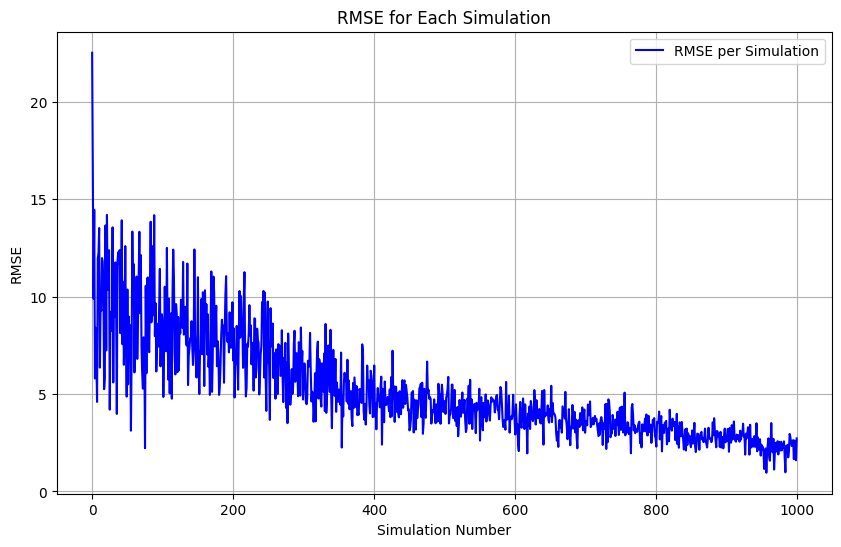

In [ ]:
# Plot the RMSE values for all realizations
plt.figure(figsize=(10, 6))
plt.plot(rmse_list, label='RMSE per Simulation', color='blue')
#plt.axhline(mean_rmse, color='red', linestyle='--', label=f'Mean RMSE: {mean_rmse:.2f}')
plt.title('RMSE for Each Simulation')
plt.xlabel('Simulation Number')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf  # or torch, depending on your model type

# Load the sample audio file
audio_file_path = '0a1b4df0-84fa-40d7-bc48-9ca0a690b5b9_v0.wav'  # Replace with your file path
y, sr = librosa.load(audio_file_path, sr=None)

# Extract features (e.g., Mel spectrogram)
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

# Visualize the Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_mel_spec, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

# Reshape the feature array to match model input shape
# Assuming the model expects (batch_size, height, width, channels)
input_data = log_mel_spec[np.newaxis, ..., np.newaxis]  # Add batch and channel dimensions

# Load the trained model
model = tf.keras.models.load_model('/path/to/your/saved_model')  # Replace with your model path

# Make a prediction
prediction = model.predict(input_data)

# Analyze the output
predicted_class = np.argmax(prediction, axis=1)
print(f'Predicted class: {predicted_class}')
print(f'Prediction probabilities: {prediction}')


In [ ]:
# Train the model
model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_test, y_test))

# Evaluate the model
#loss = model.evaluate(x_test, y_test)
#print(f'Test loss: {loss}')



Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - loss: 45.0300 - val_loss: 4.4856
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - loss: 43.9224 - val_loss: 4.0682
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - loss: 48.3002 - val_loss: 4.0915
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 239ms/step - loss: 44.5672 - val_loss: 5.9608
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - loss: 44.1507 - val_loss: 4.0590
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - loss: 45.0267 - val_loss: 4.9158
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - loss: 46.1295 - val_loss: 3.8963
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - loss: 45.4116 - val_loss: 3.8901
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step - loss: 44.6920 - val_loss: 4.9545
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - loss: 42.8497 - val_loss: 5.2479
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step - loss: 46.5072 - val_loss: 3.6699
Epoch 12/100
30/30 ━━━━━━━━

In [ ]:
# Predict the source location for the test data
predictions = model.predict(x_test)

#print first 5 predictions
print(predictions[:5])

loss = model.evaluate(x_test, y_test)
print(f'Test loss: {loss}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]]
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.9999
Test loss: 1.9998869895935059


In [ ]:
predictions.shape
y_test.shape

(469, 2)

In [ ]:
print(y_test[:5])

[[ 28.34143687 -80.7817993 ]
 [ 28.34206505 -80.78181943]
 [ 28.34229547 -80.78193907]
 [ 28.34241    -80.78209   ]
 [ 28.34226262 -80.78141985]]


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict the source location for the test data
predictions = model.predict(x_test)
print(predictions)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse}')

# Calculate the R-squared value
r_squared = r2_score(y_test, predictions)
print(f'R-squared: {r_squared}')


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.342642 -78.78171 ]
 [ 28.3426

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Custom callback for computing RMSE at each epoch
class RMSECallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_train_begin(self, logs=None):
        self.rmse_per_epoch = []

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        predictions = self.model.predict(x_val)
        rmse = np.sqrt(mean_squared_error(y_val, predictions))
        self.rmse_per_epoch.append(rmse)
        print(f'Epoch {epoch+1}, val_RMSE: {rmse}')

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Epoch 1, val_RMSE: 1.3573267622453191
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - loss: 38.0469 - val_loss: 1.8423
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 2, val_RMSE: 2.464070710903537
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - loss: 35.3047 - val_loss: 6.0716
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 3, val_RMSE: 1.4551138600239282
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - loss: 37.6796 - val_loss: 2.1174
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 4, val_RMSE: 1.066695772205733
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - loss: 39.9409 - val_loss: 1.1378
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 5, val_RMSE: 1.8836718316214367
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - loss: 36.7656 - val_loss: 3.5482
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 6, val_RMSE: 1.79599598853264
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - loss: 35.2024 - val_loss: 3.2256
Epoch 7/50


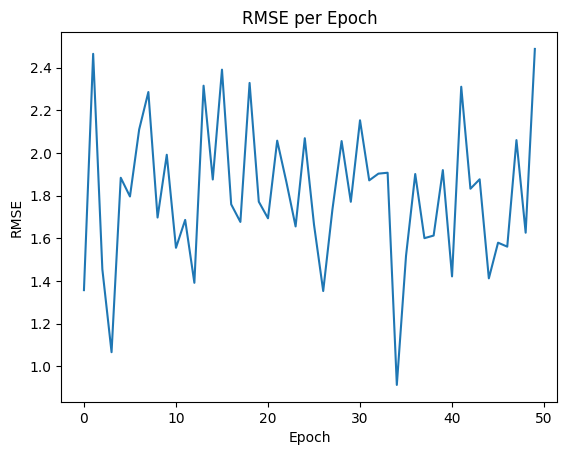

In [ ]:
# Train the model with RMSE logging
rmse_callback = RMSECallback(validation_data=(x_test, y_test))
model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test), callbacks=[rmse_callback])

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse}')

# Plotting RMSE
plt.plot(rmse_callback.rmse_per_epoch)
plt.title('RMSE per Epoch')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.show()